# 7-1: Reporting

Not everyone wants to read all your code, nor should they. But the information your Notebooks produce will be valuable to a wide range of audiences. So how to best provide the information?

Let's start by grabbing some logs. In this case, HTTP logs from Splunk's [Boss of the SOC, v1](https://github.com/splunk/botsv1). We also need to clean up the data for use in Pandas, which this will handle.

In [2]:
import os

if not os.path.exists("./iis.json"):
    ! wget https://s3.amazonaws.com/botsdataset/botsv1/json-by-sourcetype/botsv1.iis.json.gz -O iis.json.gz
    ! gunzip iis.json.gz
    ! sed -i '1s/^/[/' iis.json
    ! sed -i 's/}$/},/' iis.json
    ! sed -i '$s/,$//' iis.json
    ! echo "]" >> iis.json

--2022-11-13 17:15:38--  https://s3.amazonaws.com/botsdataset/botsv1/json-by-sourcetype/botsv1.iis.json.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.94.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.94.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 636848 (622K) [application/json]
Saving to: ‘iis.json.gz’

iis.json.gz         100%[===================>] 621.92K  1.66MB/s    in 0.4s    

2022-11-13 17:15:39 (1.66 MB/s) - ‘iis.json.gz’ saved [636848/636848]



Now, let's make some fun charts!

In [3]:
import pandas as pd
import json

with open("iis.json") as f:
    json_evts = [j["result"] for j in json.load(f) if "result" in j.keys()]

df = pd.DataFrame(json_evts)

In [4]:
df.shape

(22615, 142)

In [7]:
df.head()

,c_ip,cs_User_Agent,cs_method,cs_uri_stem,date,date_hour,date_mday,date_minute,date_month,date_second,...,module,section,do,ADMINTYPE,cmd,report,culture,rev,sections,full
0,192.168.2.50,Mozilla/4.0+(compatible;+MSIE+8.0;+Windows+NT+...,GET,/,2016-08-24,16,24,37,august,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,192.168.2.50,Mozilla/4.0+(compatible;+MSIE+8.0;+Windows+NT+...,GET,/,2016-08-24,16,24,37,august,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,192.168.2.50,Mozilla/4.0+(compatible;+MSIE+8.0;+Windows+NT+...,GET,/,2016-08-24,16,24,37,august,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,192.168.2.50,Mozilla/4.0+(compatible;+MSIE+8.0;+Windows+NT+...,GET,/,2016-08-24,16,24,37,august,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192.168.2.50,Mozilla/4.0+(compatible;+MSIE+8.0;+Windows+NT+...,GET,/dev/,2016-08-24,16,24,37,august,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import plotly.express as px

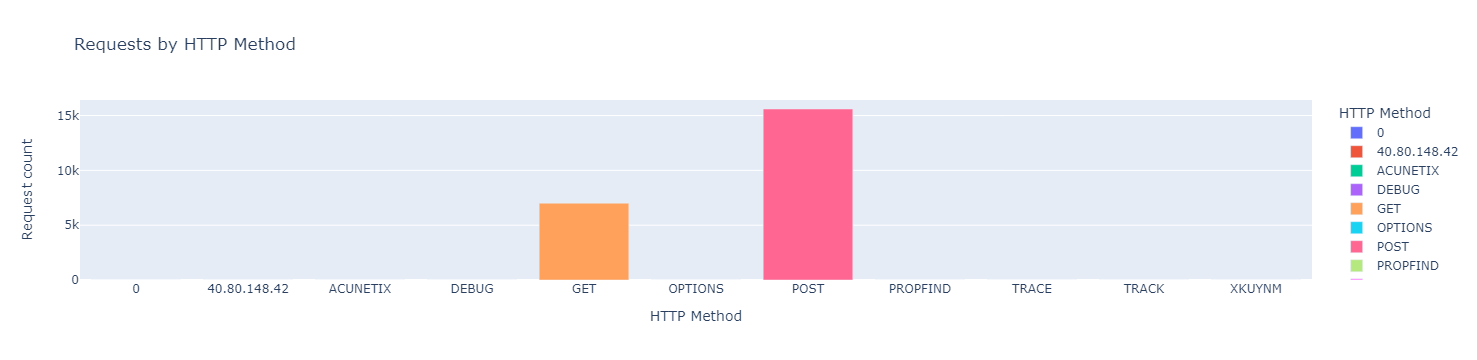

In [11]:
http_method = df.dropna(subset=["cs_method"]).groupby("cs_method").count().reset_index()
px.bar(http_method, x="cs_method", y="c_ip", labels={"cs_method": "HTTP Method", "c_ip": "Request count"}, title="Requests by HTTP Method", color="cs_method")

In [12]:
# Setup datetime
df["_time"] = pd.to_datetime(df._time.str.replace("MDT", "-0700"))

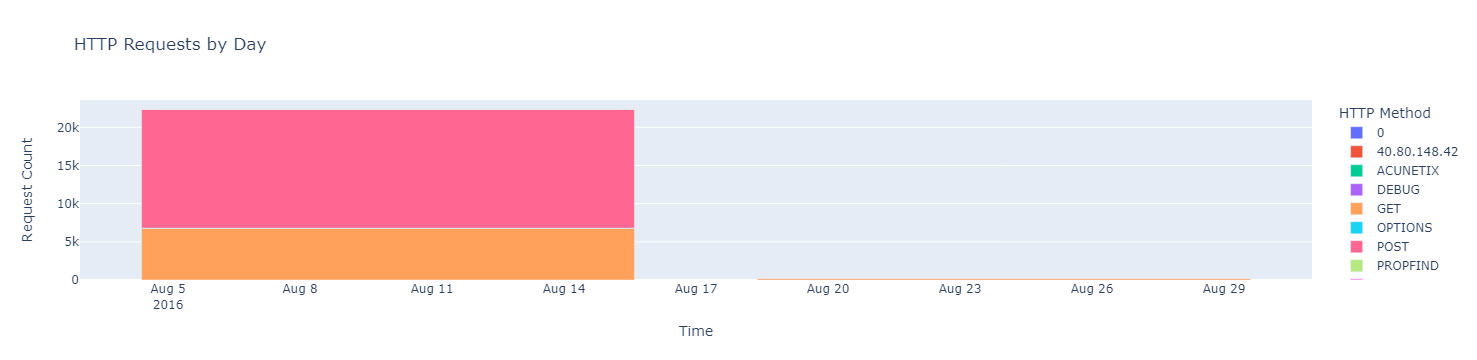

In [47]:
methods_by_time = df.groupby([pd.Grouper(key="_time", freq="1D"), "cs_method"]).count().reset_index()
px.bar(methods_by_time, x="_time", y="c_ip", labels={"_time": "Time", "c_ip": "Request Count", "cs_method": "HTTP Method"}, color="cs_method", title="HTTP Requests by Day")

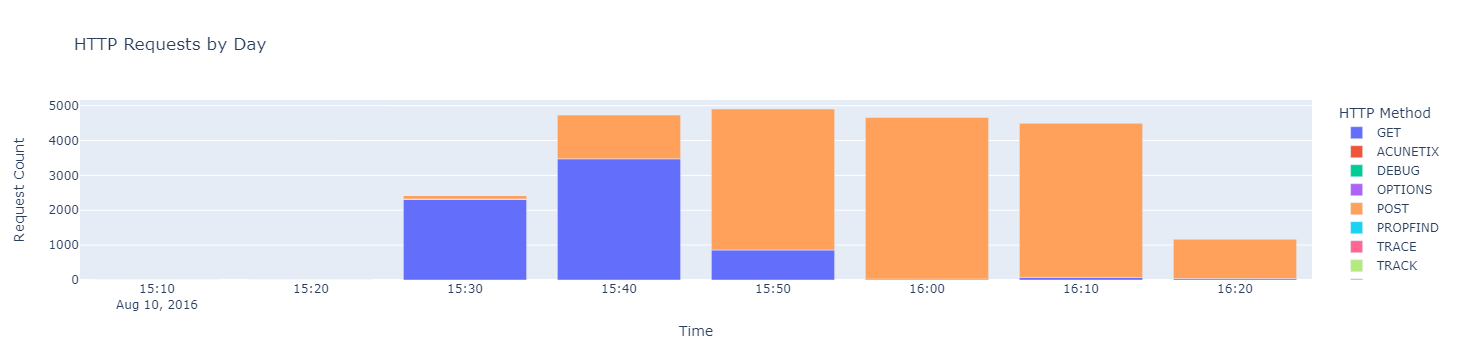

In [49]:
# Create time boundarie
aug_10 = df[df._time.dt.day == 10]
aug_10_10m_methods = aug_10.groupby([pd.Grouper(key="_time", freq="10min"), "cs_method"]).count().reset_index()
px.bar(aug_10_10m_methods, x="_time", y="c_ip", labels={"_time": "Time", "c_ip": "Request Count", "cs_method": "HTTP Method"}, color="cs_method", title="HTTP Requests by Day")

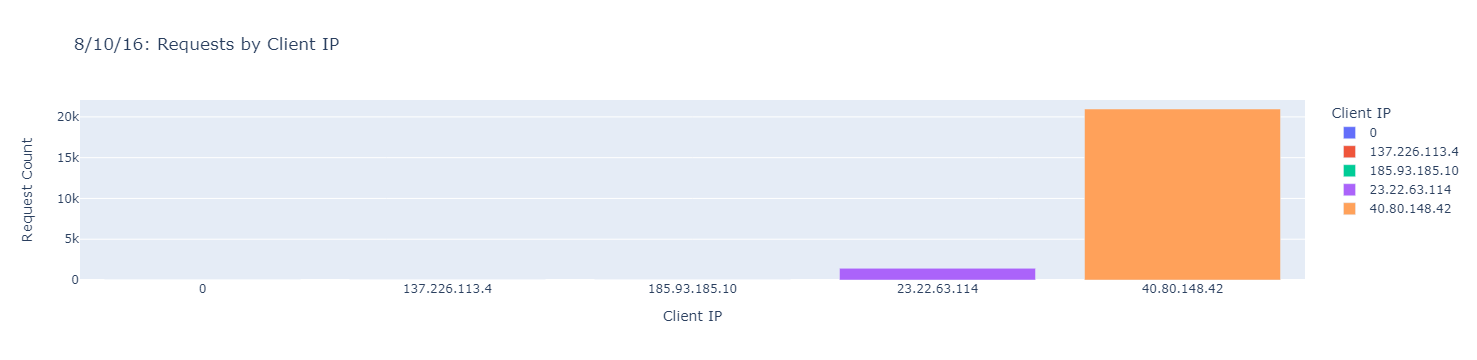

In [55]:
aug_10_s_ip = aug_10.groupby("c_ip").count().reset_index()
px.bar(aug_10_s_ip, x="c_ip", y="s_ip", labels={"c_ip": "Client IP", "s_ip": "Request Count"}, color="c_ip", title="8/10/16: Requests by Client IP")

Okay so we have all of this data, and maybe more. How do we report it?

`DataFrame`s have built-in `.to_csv()` and `.to_excel()`, but that's just tabular data. What about providing data to leadership?

Jupyter has the ability to export data to PDF as well. However, that's not preference because while it works, it's not the most visually appealing.

Instead, there's another tool I like to use for presenting findings. [Datapane](https://docs.datapane.com/jupyter-integration/#notebook-to-data-app-one-line-of-code).

Watch this:

In [57]:
import datapane as dp
app = dp.App(blocks=dp.cells_to_blocks(Out))
app.save("report.html")

Converting cells to blocks.

Please ensure all cells in the notebook have been executed and then saved before running this command.

App saved to ./report.html

How about that?! Did you notice that the Markdown cell above wasn't included? I can take cells with `dp-exclude` to keep them out of the report.

Also, look at what you can do with the Pandas table!

I like the Datapane export because it unites the clarity of a PDF with the interactivity of a Notebook.

You could also imagine exporting a report on a regular basis, hosting it on an internal webserver.

## The End

Aaaand...that's it!

This is the Last Notebook. You made it! Congratulations!

If you've practiced the skills and techniques in this course, you'll be ready for the Exhibition of Mastery. There's one more unit on Next Steps, then: the Exhibition!

Congratulations, and thank you for your time, attention, and support of the Taggart Institute. I hope you've found the course worthwhile.


\- Michael